## Protein Embeddings Manipulation

In [1]:
from pathlib import Path

data_path = Path("../data/Protera") 

!ls $data_path

clustering     prism			       stability_test.h5
cluster.out    search.out		       stability_train.csv
data.csv       sequences.fasta		       stability_train.h5
mmseq	       stability.csv		       stability_with_dups.csv
mmseq_q        stability_embeddings_test.pkl   tmp
mmseq_t        stability_embeddings_train.pkl
prefilter.out  stability_test.csv


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt

from protera_stability.data import ProteinStabilityDataset

### Get Dataset

In [3]:
train_set = ProteinStabilityDataset(proteins_path=data_path / "stability_train.h5")

In [4]:
train_set.X.mean(), train_set.X.var(), train_set.X.shape

(-3.655451e-10, 1.0, (7201, 1280))

In [6]:
train_set.y.mean(), train_set.y.var(), train_set.y.shape

(6.886691e-09, 1.0, (7201,))

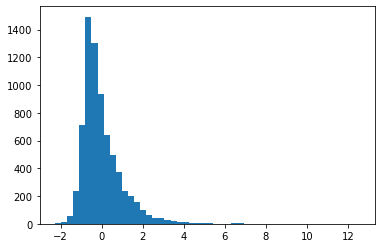

In [8]:
plt.hist(train_set.y, bins=50)
plt.show()

## Dimensionality Reduction

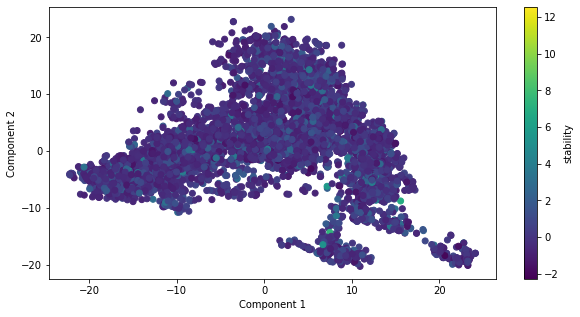

In [12]:
from protera_stability.utils.decomposition import dim_reduction

X = dim_reduction(train_set.X, train_set.y, n_components=32, plot_viz=True, prefix="stability")

In [14]:
from protera_stability.train import perform_search

from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_set.X, train_set.y, random_state=123)

scoring = "r2"
score = r2_score
models = {
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1.0, 10.0],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": [3],
            "gamma": ["scale"],
        },
    },
    "MLP": {
        "model": MLPRegressor(),
        "params": {
            "hidden_layer_sizes": [(100,), (100, 100), (1024, 1024)],
            "activation": ["tanh", "relu"],
            "solver": ["sgd", "adam"],
        },
    },
}

for name, model in models.items():
    perform_search(
        X_train,
        y_train,
        model["model"],
        model["params"],
        name,
        X_test=X_val,
        y_test=y_val,
        save_dir="../models",
        n_jobs=8,
    )

ModuleNotFoundError: No module named 'protera_stability.trainer'

In [ ]:
X_test, y_test = load_dataset_raw(data_path, kind="test", scale=True)
X_test = dim_reduction(X_test, y_test, n_components=32, plot_viz=False)

In [ ]:
model = SVR(**{'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'})

model.fit(X_train, y_train)
model.score(X_test, y_test)

In [ ]:
model = MLPRegressor(**{'activation': 'relu', 'hidden_layer_sizes': (1024, 1024), 'solver': 'adam'})

model.fit(X_train, y_train)
model.score(X_test, y_test)

## Can a FeedForward Net do better?


In [ ]:
from torch import nn
import torch.nn.functional as F

class ProteinMLP(nn.Module):
    def __init__(self, n_in = 1280, n_units = 1024, act = None, drop_p = 0.7, last_drop = False):
        super(ProteinMLP, self).__init__()
        self.fc1 = nn.Linear(n_in, n_units)
        self.fc2 = nn.Linear(n_units, n_units//2)
        self.fc3 = nn.Linear(n_units//2, 1)
        
        self.drop = nn.Dropout(p=drop_p)
        self.last_drop = last_drop
        self.act = act
        if act is None:
            self.act = nn.LeakyReLU()
            
    def forward(self, x):
        out = self.act(self.drop(self.fc1(x)))
        out = self.act(self.drop(self.fc2(out)))
        out = self.fc3(out)
        
        if self.last_drop: 
            out = self.drop(out)
        return self.act(out)

In [ ]:
from skorch.callbacks import Checkpoint, LRScheduler, EarlyStopping
from skorch import NeuralNetRegressor

cb = Checkpoint(dirname='models')
sched = LRScheduler(step_every="batch")
stopper = EarlyStopping(patience=15)

net = NeuralNetRegressor(
    ProteinMLP,
    max_epochs=int(1e4),
    lr=1e-3,
    iterator_train__shuffle=True,
    device='cuda',
    callbacks=[cb, sched, stopper],
    module__n_units=1024
)

X_train, y_train = load_dataset(data_path, kind = 'train', reduce = False, to_torch = True, close_h5 = True)
X_test, y_test = load_dataset(data_path, kind = 'test', reduce = False, to_torch = True, close_h5 = True)

net.fit(X_train, y_train)

In [ ]:
net.score(X_test, y_test)